In [ ]:
import pandas as pd

# Load the CSV file
file_path = '3002.csv'
df = pd.read_csv(file_path)

# Ensure the 'prcp(mm/day)' column is numeric
df['prcp(mm/day)'] = pd.to_numeric(df['prcp(mm/day)'], errors='coerce')

# Convert 'Date' column to datetime format and keep only the date
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Drop the 'pet_gleam(mm/day)' column (no longer needed)
df = df.drop(columns=['pet_gleam(mm/day)'])

# Filter rows where precipitation is zero
df = df[df['prcp(mm/day)'] == 0]

# Ensure strictly decreasing streamflow
df = df.loc[df['Streamflow'].diff().lt(0) | df['Streamflow'].diff().isna()]

# Identify gaps between consecutive dates
df['date_diff'] = df['Date'].diff().fillna(pd.Timedelta(days=1)).dt.days.astype(int)

# Define groups based on consecutive dates
df['group'] = (df['date_diff'] > 1).cumsum()

# Remove the first 3 rows from each group (if size > 3)
filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)

# Keep only groups with at least 6 rows
valid_groups = filtered['group'].value_counts()
valid_groups = valid_groups[valid_groups >= 6].index
filtered = filtered[filtered['group'].isin(valid_groups)]

# Drop helper columns
filtered = filtered.drop(columns=['date_diff', 'group'])

# Add blank rows between groups
output = []
for _, group in filtered.groupby((filtered['Date'].diff() > pd.Timedelta(days=1)).cumsum()):
    output.append(group)  # Add the group
    output.append(pd.DataFrame({col: [''] for col in group.columns}))  # Add a blank row

# Concatenate the final results
final_result = pd.concat(output, ignore_index=True)

# Save the final result to a CSV file
final_result.to_csv('3002_filtered_results_final.csv', index=False)

# Show the final result (optional)
pd.set_option('display.max_rows', None)
print(final_result)
pd.reset_option('display.max_rows')


FileNotFoundError: [Errno 2] No such file or directory: '3002.csv'

In [ ]:
df=final_result
df['Streamflow'] = pd.to_numeric(df['Streamflow'], errors='coerce')

##Split the Streamflow column into sublists, separating by NaNs
sublists = [group["Streamflow"].tolist() for _, group in df[df["Streamflow"].notna()].groupby((df["Streamflow"].isna()).cumsum())]



In [ ]:
len(sublists)

17

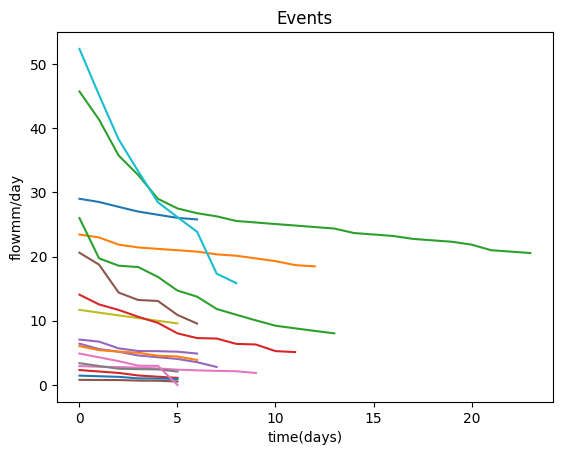

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(sublists)):
  h=sublists[i]
  plt.plot(range(len(h)),h)
plt.xlabel("time(days)")
plt.ylabel('flowmm/day')
plt.title("Events")
plt.show()

In [ ]:
import pandas as pd
import glob
import os

# Grab all uploaded CSV files in the current working directory
csv_files = glob.glob("*.csv")

# List to store result for each file
summary_data = []

for file_path in csv_files:
    try:
        df = pd.read_csv(file_path)

        # Ensure 'prcp(mm/day)' is numeric
        df['prcp(mm/day)'] = pd.to_numeric(df['prcp(mm/day)'], errors='coerce')

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date']).dt.date

        # Drop the 'pet_gleam(mm/day)' column if it exists
        if 'pet_gleam(mm/day)' in df.columns:
            df = df.drop(columns=['pet_gleam(mm/day)'])

        # Filter for zero precipitation
        df = df[df['prcp(mm/day)'] == 0]

        # Ensure strictly decreasing streamflow
        df = df.loc[df['Streamflow'].diff().lt(0) | df['Streamflow'].diff().isna()]

        # Identify date gaps and group
        df['date_diff'] = df['Date'].diff().fillna(pd.Timedelta(days=1)).dt.days.astype(int)
        df['group'] = (df['date_diff'] > 1).cumsum()

        # Remove first 3 rows of each group (if size > 3)
        filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)

        # Keep only groups with at least 6 rows
        valid_groups = filtered['group'].value_counts()
        valid_groups = valid_groups[valid_groups >= 6].index
        filtered = filtered[filtered['group'].isin(valid_groups)]

        # Drop helper columns
        filtered = filtered.drop(columns=['date_diff', 'group'])

        # Add blank rows between event groups
        output = []
        for _, group in filtered.groupby((filtered['Date'].diff() > pd.Timedelta(days=1)).cumsum()):
            output.append(group)
            output.append(pd.DataFrame({col: [''] for col in group.columns}))

        # Check and concatenate only if there's data
        if output:
            final_result = pd.concat(output, ignore_index=True)

            # Convert Streamflow to numeric
            final_result['Streamflow'] = pd.to_numeric(final_result['Streamflow'], errors='coerce')

            # Split Streamflow column into sublists, separated by NaNs
            sublists = [group["Streamflow"].tolist() for _, group in final_result[final_result["Streamflow"].notna()].groupby((final_result["Streamflow"].isna()).cumsum())]

            # Record the number of valid events
            summary_data.append({
                'filename': os.path.basename(file_path),
                'num_events': len(sublists)
            })
        else:
            summary_data.append({
                'filename': os.path.basename(file_path),
                'num_events': 0
            })
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        summary_data.append({
            'filename': os.path.basename(file_path),
            'num_events': 'error'
        })

# Save summary as a CSV
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("event_counts_summary.csv", index=False)

# Display summary
summary_df


<ipython-input-1-084bf4f7c2bd>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)
<ipython-input-1-084bf4f7c2bd>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)
<ipython-input-1-084bf4f7c2bd>:36: Depreca

,filename,num_events
0,17007.csv,0
1,8006.csv,17
2,15008.csv,4
3,5013.csv,11
4,4003.csv,3
...,...,...
122,5023.csv,0
123,4012.csv,4
124,5022.csv,0
125,4064.csv,3


In [ ]:
!apt-get install -y libgeos-dev
!pip install cartopy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 99.5 MB/s eta 0:00:00


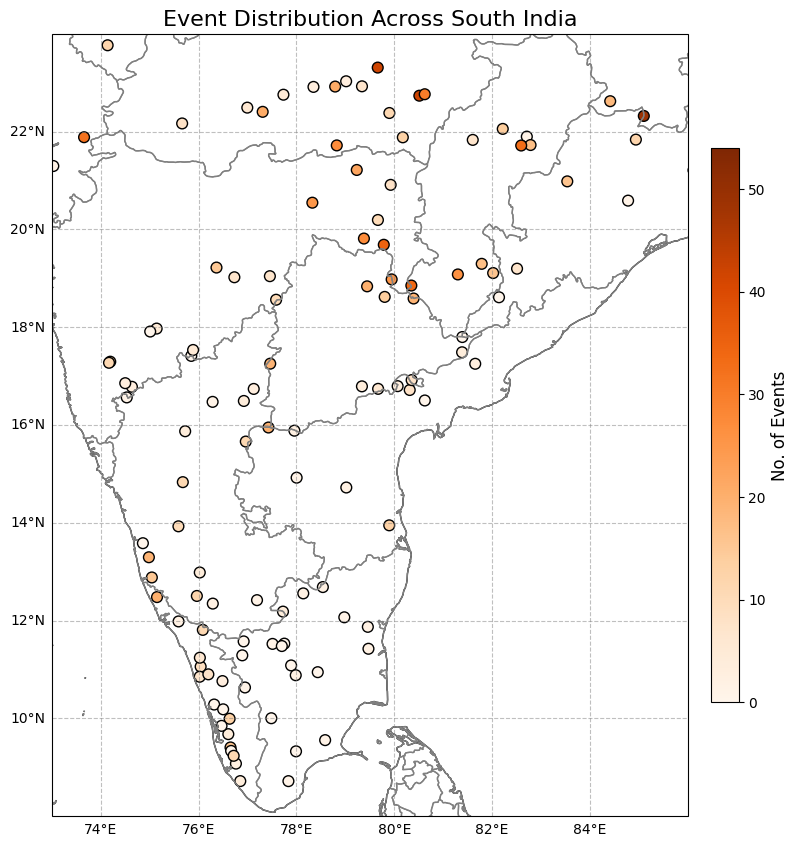

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Load the CSV files
events_df = pd.read_csv("events_count.csv")
info_df = pd.read_csv("Data_Information.csv")

# Normalize column names (optional but good for safety)
info_df.columns = info_df.columns.str.upper()
events_df["GAGE_ID"] = events_df["filename"].str.replace(".csv", "", regex=False).astype(str)
info_df["GAGE_ID"] = info_df["GAGE_ID"].astype(str)

# Merge the two DataFrames
merged = pd.merge(info_df, events_df, on="GAGE_ID")

# Plotting the map
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# South India extent
ax.set_extent([73, 86, 8, 24], crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Scatter plot
sc = ax.scatter(
    merged["LONGITUDE"],
    merged["LATITUDE"],
    c=merged["num_events"],
    cmap='Oranges',
    s=60,
    edgecolor='black',
    vmin=0,
    vmax=merged["num_events"].max(),
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
cbar.set_label("No. of Events", fontsize=12)


# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()



# Title
plt.title("Event Distribution Across South India", fontsize=16)
plt.savefig("south_india_event_map.pdf", format="pdf", bbox_inches="tight")
plt.show()


caluclating a and b for a for each event of a catchment

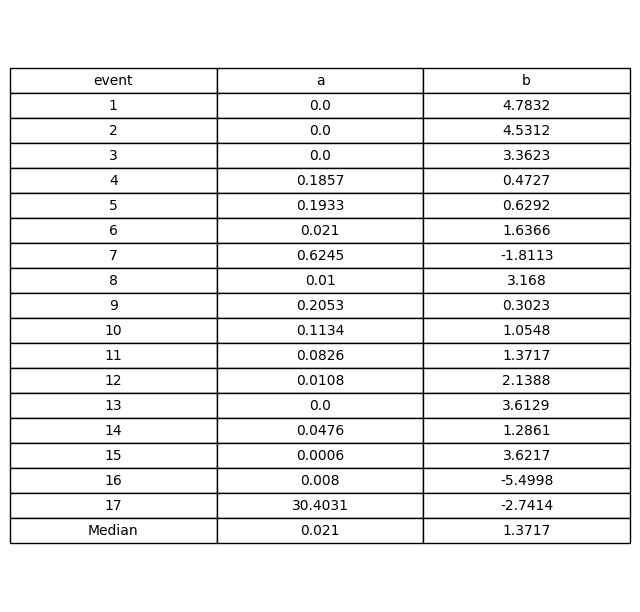

Median of a: 0.0210
Median of b: 1.3717


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Step 1: Define the model function
def model(Q, a, b):
    return a * Q**b

# Step 2: Load the filtered CSV
df = pd.read_csv('3002_filtered_results.csv')

# Convert 'Streamflow' to numeric
df['Streamflow'] = pd.to_numeric(df['Streamflow'], errors='coerce')

# Step 3: Split into event groups (blank rows separate groups)
event_groups = [
    group["Streamflow"].dropna().reset_index(drop=True)
    for _, group in df[df["Streamflow"].notna()].groupby((df["Streamflow"].isna()).cumsum())
]

# Step 4: Fit model for each group and store results
results = []

for i, q_series in enumerate(event_groups, 1):
    if len(q_series) < 2:
        results.append({"event": i, "a": np.nan, "b": np.nan})
        continue

    Q = q_series[:-1].values
    dQ = q_series.diff().dropna().values
    delta_Q = -dQ

    try:
        popt, _ = curve_fit(model, Q, delta_Q, p0=[1, 1], maxfev=10000)
        a, b = popt
        results.append({"event": i, "a": a, "b": b})
    except:
        results.append({"event": i, "a": np.nan, "b": np.nan})

# Step 5: Create result DataFrame and save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv("3002_ab_parameters.csv", index=False)

# Step 6: Calculate median
valid_results = results_df.dropna(subset=['a', 'b'])
median_a = valid_results['a'].median()
median_b = valid_results['b'].median()

# Step 7: Append median row for display
results_df_display = results_df.copy()
results_df_display[['a', 'b']] = results_df_display[['a', 'b']].round(4)

median_row = pd.DataFrame([{
    "event": "Median",
    "a": round(median_a, 4),
    "b": round(median_b, 4)
}])

results_df_display = pd.concat([results_df_display, median_row], ignore_index=True)

# Step 8: Save as PDF table
fig, ax = plt.subplots(figsize=(8, 0.5 + 0.4 * len(results_df_display)))
ax.axis('off')
table = ax.table(
    cellText=results_df_display.values,
    colLabels=results_df_display.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig("3002_ab_parameters.pdf", bbox_inches="tight")
plt.show()

# Print medians
print(f"Median of a: {median_a:.4f}")
print(f"Median of b: {median_b:.4f}")


a nd b for all the files

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import glob
import os

# Model function
def model(Q, a, b):
    return a * Q**b

# Storage for final results
summary_data = []

# Process each CSV file
for file_path in glob.glob("*.csv"):
    try:
        df = pd.read_csv(file_path)

        # Step 1: Preprocessing
        df['prcp(mm/day)'] = pd.to_numeric(df['prcp(mm/day)'], errors='coerce')
        df['Streamflow'] = pd.to_numeric(df['Streamflow'], errors='coerce')
        df['Date'] = pd.to_datetime(df['Date']).dt.date

        if 'pet_gleam(mm/day)' in df.columns:
            df.drop(columns=['pet_gleam(mm/day)'], inplace=True)

        # Step 2: Apply filtering rules
        df = df[df['prcp(mm/day)'] == 0]
        df = df.loc[df['Streamflow'].diff().lt(0) | df['Streamflow'].diff().isna()]

        df['date_diff'] = df['Date'].diff().fillna(pd.Timedelta(days=1)).dt.days.astype(int)
        df['group'] = (df['date_diff'] > 1).cumsum()

        filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)

        valid_groups = filtered['group'].value_counts()
        valid_groups = valid_groups[valid_groups >= 6].index
        filtered = filtered[filtered['group'].isin(valid_groups)]

        filtered = filtered.drop(columns=['date_diff', 'group'])

        # Step 3: Separate events using blank row logic
        output = []
        for _, group in filtered.groupby((filtered['Date'].diff() > pd.Timedelta(days=1)).cumsum()):
            output.append(group)
            output.append(pd.DataFrame({col: [''] for col in group.columns}))

        if not output:
            summary_data.append({
                'GAGE_ID': os.path.basename(file_path).replace(".csv", ""),
                'num_events': 0,
                'a_median': np.nan,
                'b_median': np.nan
            })
            continue

        final_result = pd.concat(output, ignore_index=True)
        final_result['Streamflow'] = pd.to_numeric(final_result['Streamflow'], errors='coerce')

        # Step 4: Group by blank rows and fit model per event
        sublists = [
            group["Streamflow"].dropna().reset_index(drop=True)
            for _, group in final_result[final_result["Streamflow"].notna()].groupby((final_result["Streamflow"].isna()).cumsum())
        ]

        ab_list = []
        for g in sublists:
            if len(g) < 2:
                continue
            Q = g[:-1].values
            delta_Q = -g.diff().dropna().values
            try:
                popt, _ = curve_fit(model, Q, delta_Q, p0=[1, 1], maxfev=10000)
                ab_list.append(popt)
            except:
                continue

        # Step 5: Store results
        if ab_list:
            ab_array = np.array(ab_list)
            a_median = np.median(ab_array[:, 0])
            b_median = np.median(ab_array[:, 1])
            num_events = len(ab_list)
        else:
            a_median = np.nan
            b_median = np.nan
            num_events = 0

        summary_data.append({
            'GAGE_ID': os.path.basename(file_path).replace(".csv", ""),
            'num_events': num_events,
            'a_median': a_median,
            'b_median': b_median
        })

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        summary_data.append({
            'GAGE_ID': os.path.basename(file_path).replace(".csv", ""),
            'num_events': 'error',
            'a_median': np.nan,
            'b_median': np.nan
        })

# Step 6: Save as CSV
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("catchment_ab_summary.csv", index=False)

print("Saved: catchment_ab_summary.csv")
summary_df


/tmp/ipython-input-8-1748416817.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)
/tmp/ipython-input-8-1748416817.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)
/tmp/ipython-input-8-1748416817.py

Saved: catchment_ab_summary.csv


/tmp/ipython-input-8-1748416817.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('group').apply(lambda x: x.iloc[3:] if len(x) > 3 else x).reset_index(drop=True)


,GAGE_ID,num_events,a_median,b_median
0,15008,4,1.299066,0.485965
1,4028,8,0.133613,1.184560
2,9012,1,0.195997,0.581620
3,5010,12,0.001954,2.370222
4,3029,7,0.135744,1.196008
...,...,...,...,...
122,3071,33,0.000408,2.725954
123,8003,1,-0.707712,-8.276554
124,10011,12,1.549388,0.275750
125,8031,16,0.055524,1.194153


In [ ]:
!apt-get install -y libgeos-dev
!pip install cartopy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.4 MB/s eta 0:00:00


plot of a and b

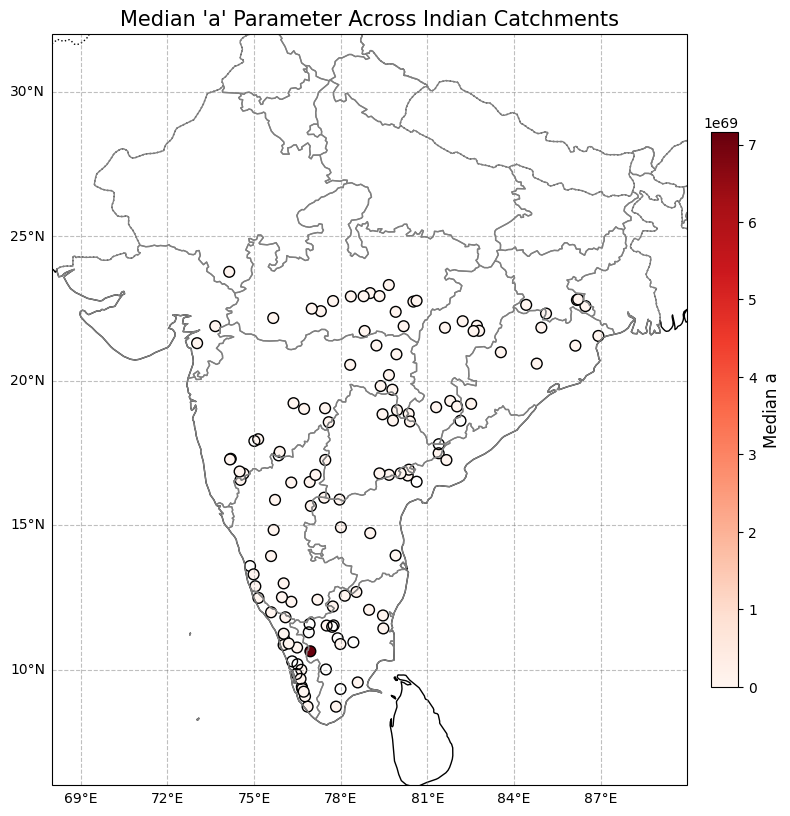

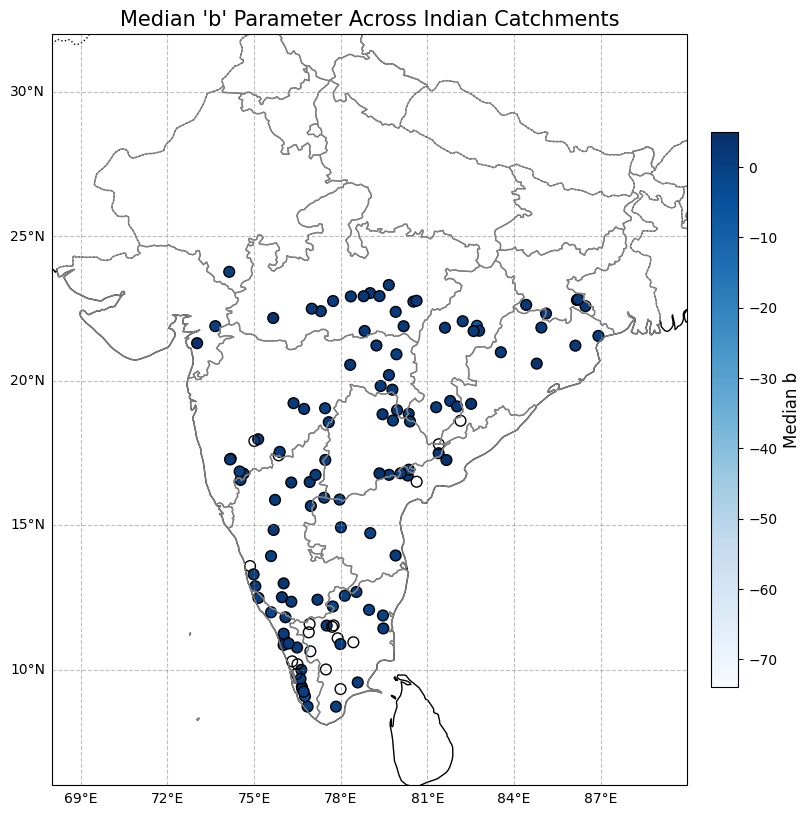

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Load the files
ab_df = pd.read_csv("catchment_ab_summary.csv")
coord_df = pd.read_csv("Data_Information.csv")

# Standardize column names
coord_df.columns = coord_df.columns.str.upper()
ab_df["GAGE_ID"] = ab_df["GAGE_ID"].astype(str)
coord_df["GAGE_ID"] = coord_df["GAGE_ID"].astype(str)

# Merge coordinates with median a, b, and num_events
merged_df = pd.merge(coord_df, ab_df, on="GAGE_ID")

def plot_parameter_map(df, value_column, cmap, title, filename, color_label):
    fig = plt.figure(figsize=(10, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([68, 90, 6, 32], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, edgecolor='gray')

    sc = ax.scatter(
        df["LONGITUDE"],
        df["LATITUDE"],
        c=df[value_column],
        cmap=cmap,
        edgecolor="black",
        s=60,
        transform=ccrs.PlateCarree()
    )

    cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
    cbar.set_label(color_label, fontsize=12)

    gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    plt.title(title, fontsize=15)
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.show()

# Plot Median a map
plot_parameter_map(
    merged_df,
    value_column="a_median",
    cmap="Reds",
    title="Median 'a' Parameter Across Indian Catchments",
    filename="median_a_map",
    color_label="Median a"
)

# Plot Median b map
plot_parameter_map(
    merged_df,
    value_column="b_median",
    cmap="Blues",
    title="Median 'b' Parameter Across Indian Catchments",
    filename="median_b_map",
    color_label="Median b"
)


In [ ]:
!apt-get install libproj-dev proj-data proj-bin libgeos-dev -y
!pip install --no-binary :all: cartopy


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libproj-dev is already the newest version (9.3.1-1~jammy0).
libproj-dev set to manually installed.
proj-data is already the newest version (9.3.1-1~jammy0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 205 kB of archives.
After this operation, 521 kB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 proj-bin amd64 9.3.1-1~jammy0 [205 kB]
Fetched 205 kB in 1s (252 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.3.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.3.1-1~jammy0) ...
Setting up proj-bin (9.3.1-1~jammy0) ...
Processing tr

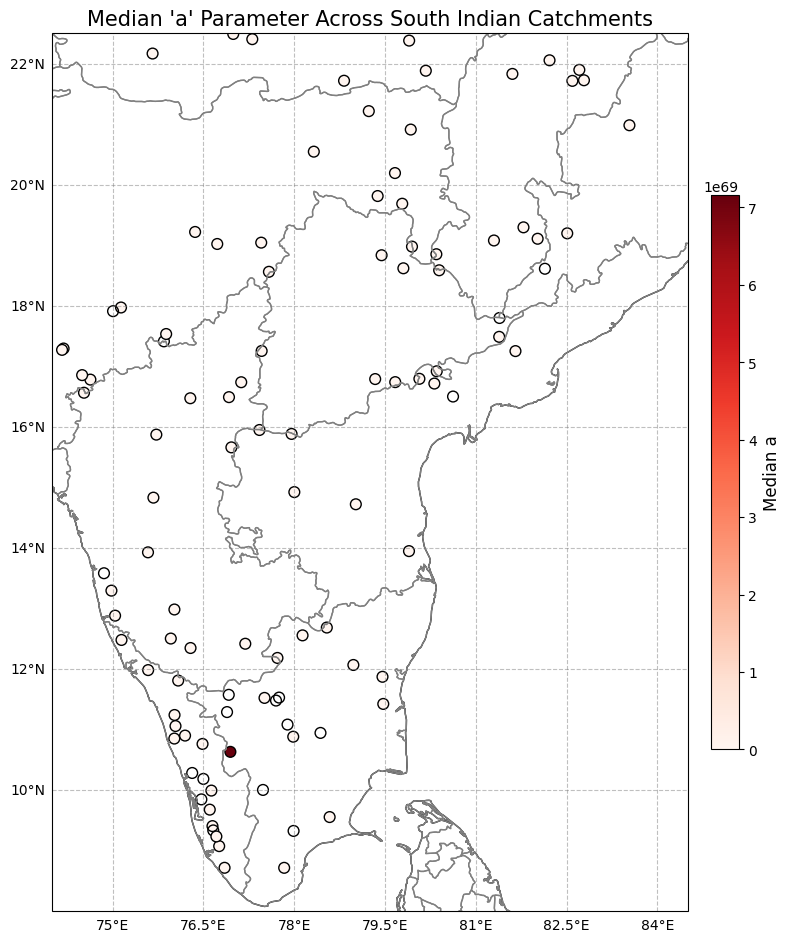

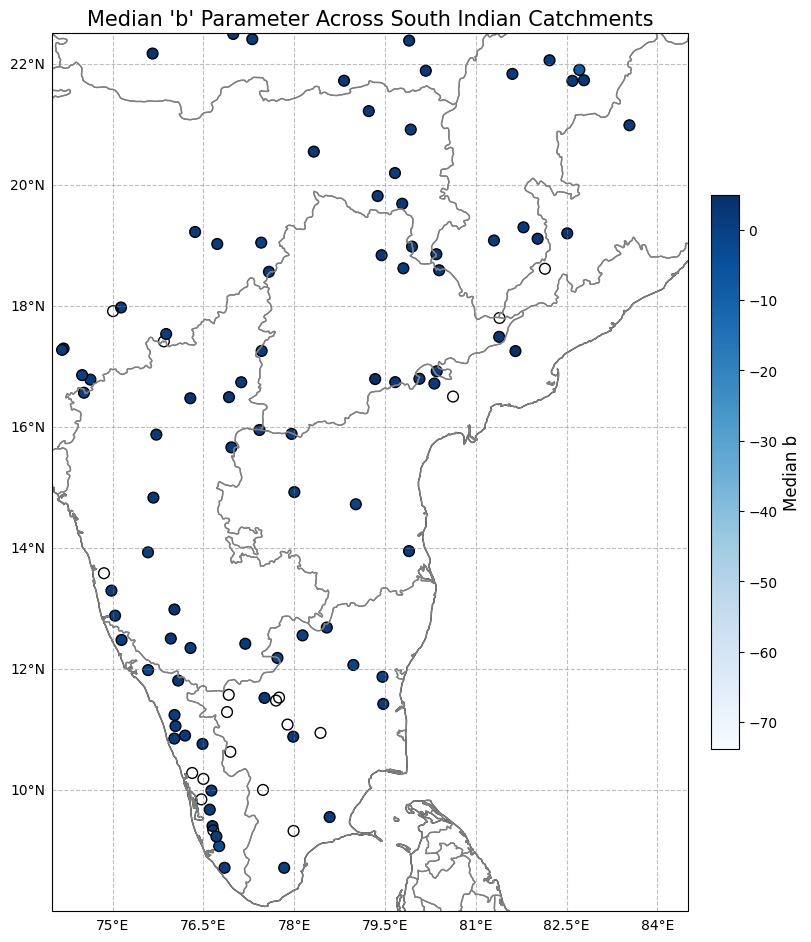

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Load data
ab_df = pd.read_csv("catchment_ab_summary.csv")
coord_df = pd.read_csv("Data_Information.csv")

# Standardize column names
coord_df.columns = coord_df.columns.str.upper()
ab_df["GAGE_ID"] = ab_df["GAGE_ID"].astype(str)
coord_df["GAGE_ID"] = coord_df["GAGE_ID"].astype(str)

# Merge coordinate + a/b data
merged_df = pd.merge(coord_df, ab_df, on="GAGE_ID")

# Plotting function
def plot_parameter_map(df, value_column, cmap, title, filename, color_label):
    fig = plt.figure(figsize=(10, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Zoom to South India
    ax.set_extent([74, 84.5, 8, 22.5], crs=ccrs.PlateCarree())

    # Map features
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, edgecolor='gray')

    # Scatter plot
    sc = ax.scatter(
        df["LONGITUDE"],
        df["LATITUDE"],
        c=df[value_column],
        cmap=cmap,
        edgecolor="black",
        s=60,
        transform=ccrs.PlateCarree()
    )

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
    cbar.set_label(color_label, fontsize=12)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Title and Save
    plt.title(title, fontsize=15)
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.show()

# Plot map for median a
plot_parameter_map(
    merged_df,
    value_column="a_median",
    cmap="Reds",
    title="Median 'a' Parameter Across South Indian Catchments",
    filename="a_median_map",
    color_label="Median a"
)

# Plot map for median b
plot_parameter_map(
    merged_df,
    value_column="b_median",
    cmap="Blues",
    title="Median 'b' Parameter Across South Indian Catchments",
    filename="b_median_map",
    color_label="Median b"
)
